In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import itertools

In [97]:
# (8.a)

np.random.seed(69)

x = np.random.normal(0, 1, 100)

e = np.random.normal(0, 1, 100)

In [98]:
# (8.b) 

b_0 = 1
b_1 = 2
b_2 = 3
b_3 = 4 

y = b_0 + b_1 * x + b_2 * (x**2) + b_3 * (x**3) + e 

<Axes: >

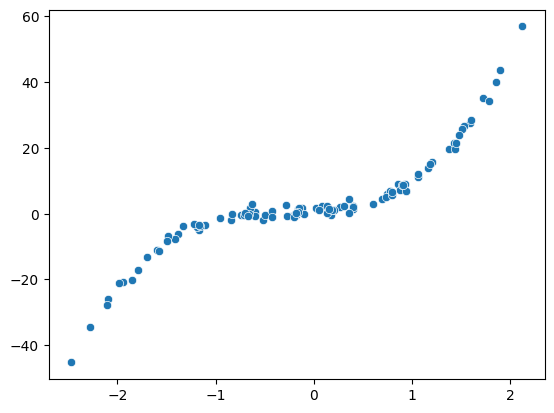

In [99]:
sns.scatterplot(x=x, y=y)

In [100]:
# (8.c) Forward Selection

df = pd.DataFrame({
    'X1': x,
    'X2': x**2,
    'X3': x**3,
    'X4': x**4,
    'X5': x**5,
    'X6': x**6,
    'X7': x**7,
    'X8': x**8,
    'X9': x**9,
    'X10': x**10
})

df['Y'] = y 

df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.915507,0.838153,0.767335,0.702501,0.643145,0.588803,0.539054,0.493507,0.451810,0.413635,8.085530
1,-0.603542,0.364263,-0.219848,0.132687,-0.080082,0.048333,-0.029171,0.017606,-0.010626,0.006413,0.539997
2,1.162295,1.350930,1.570179,1.825012,2.121203,2.465464,2.865596,3.330669,3.871220,4.499501,13.925221
3,-0.601400,0.361682,-0.217516,0.130814,-0.078672,0.047313,-0.028454,0.017112,-0.010291,0.006189,-0.616998
4,-1.597486,2.551960,-4.076720,6.512502,-10.403629,16.619647,-26.549648,42.412683,-67.753652,108.235488,-10.955033


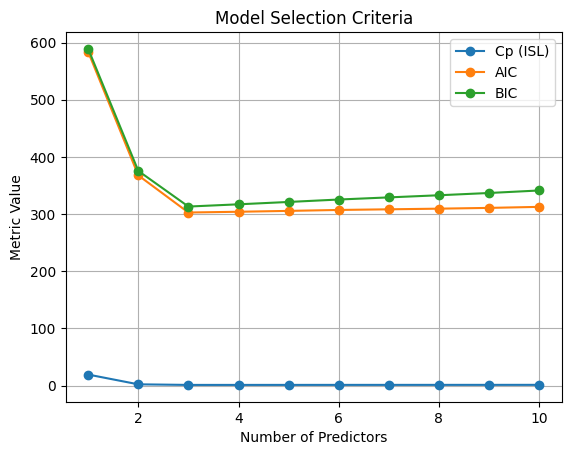

Selected Features: ['X3', 'X2', 'X1', 'X5', 'X4', 'X6', 'X9', 'X7', 'X8', 'X10']
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1827.
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           2.01e-98
Time:                        14:09:00   Log-Likelihood:                -145.31
No. Observations:                 100   AIC:                             312.6
Df Residuals:                      89   BIC:                             341.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [101]:
# Estimate sigma^2 from full model
X_full = sm.add_constant(df.drop(columns='Y'))
y_full = df['Y']
model = sm.OLS(y_full, X_full).fit()
sigma2_hat = model.mse_resid

remaining_features = list(df.columns[:-1])

selected, cp, aic, bic = [], [], [], []

n = len(df)

for k in range(1, len(remaining_features) + 1):
    best_cp = np.inf
    best_feature = None
    
    for feature in remaining_features:
        trial_features = selected + [feature]
        X_trial = sm.add_constant(df[trial_features])
        y = df['Y']
        model = sm.OLS(y, X_trial).fit()
        rss = ((model.predict(X_trial) - y)**2).sum()
        d = len(trial_features) + 1  # including intercept
        curr_cp = (rss + 2 * d * sigma2_hat) / n
        if curr_cp < best_cp:
            best_cp = curr_cp
            best_feature = feature
            best_model = model
            best_rss = rss
    
    selected.append(best_feature)
    remaining_features.remove(best_feature)
    cp.append(best_cp)
    aic.append(best_model.aic)
    bic.append(best_model.bic)

num_features = list(range(1, 11))

plt.plot(num_features, cp, marker='o', label='Cp (ISL)')
plt.plot(num_features, aic, marker='o', label='AIC')
plt.plot(num_features, bic, marker='o', label='BIC')

plt.xlabel('Number of Predictors')
plt.ylabel('Metric Value')
plt.title('Model Selection Criteria')
plt.legend()
plt.grid(True)
plt.show()

print("Selected Features:", selected)

print(best_model.summary())

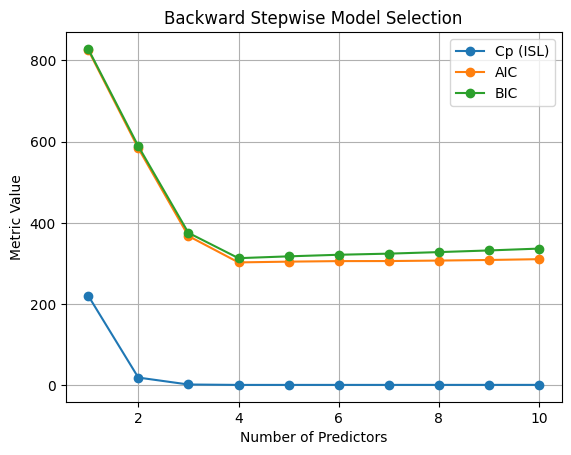

Removed Features: ['X5', 'X9', 'X7', 'X4', 'X10', 'X6', 'X8', 'X1', 'X2', 'X3']
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 07 Aug 2025   Prob (F-statistic):                nan
Time:                        14:09:01   Log-Likelihood:                -411.78
No. Observations:                 100   AIC:                             825.6
Df Residuals:                      99   BIC:                             828.2
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [102]:
# (8.d) Backward Selection

current_features = list(df.columns[:-1])

removed = []

cp, aic, bic = [], [], []

for k in range(len(current_features), 0, -1):
    best_cp = np.inf
    worst_feature = None
    
    for feature in current_features:
        trial_features = [f for f in current_features if f != feature]
        X_trial = sm.add_constant(df[trial_features])
        y = df['Y']
        model = sm.OLS(y, X_trial).fit()
        rss = ((model.predict(X_trial) - y)**2).sum()
        d = len(trial_features) + 1  
        curr_cp = (rss + 2 * d * sigma2_hat) / n
        if curr_cp < best_cp:
            best_cp = curr_cp
            worst_feature = feature
            best_model = model
    
    cp.append(best_cp)
    aic.append(best_model.aic)
    bic.append(best_model.bic)
    
    current_features.remove(worst_feature)
    removed.append(worst_feature)

num_features = list(range(10, 0, -1))

plt.plot(num_features, cp, marker='o', label='Cp (ISL)')
plt.plot(num_features, aic, marker='o', label='AIC')
plt.plot(num_features, bic, marker='o', label='BIC')

plt.xlabel('Number of Predictors')
plt.ylabel('Metric Value')
plt.title('Backward Stepwise Model Selection')
plt.legend()
plt.grid(True)
plt.show()

print("Removed Features:", removed)

print(best_model.summary())

In [103]:
# Selected Features: ['X3', 'X2', 'X1', 'X5', 'X4', 'X6', 'X9', 'X7', 'X8', 'X10']

# Removed Features: ['X5', 'X9', 'X7', 'X4', 'X10', 'X6', 'X8', 'X1', 'X2', 'X3']

# X3, X2, X1 are the strongest features — they are added first in forward selection and removed last in backward selection.

# Higher-order terms (like X6–X10) are less important, and are added late / removed early.

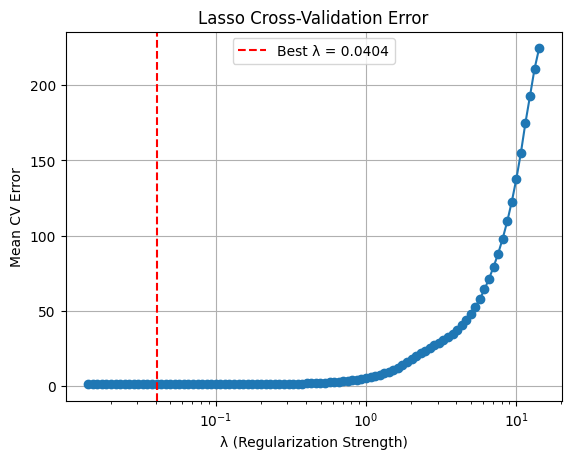

Best lambda (alpha): 0.04044249252116813
Intercept: 3.202761072726131
Selected Features (non-zero coefficients):
X1     2.203636
X2     4.087094
X3    13.681489
dtype: float64


In [104]:
# (8.e) Fit lasso model

poly = PolynomialFeatures(degree=10, include_bias=False)

X_poly = poly.fit_transform(x.reshape(-1, 1))

feature_names = [f"X{i}" for i in range(1, 11)]

scaler = StandardScaler()

X_poly_scaled = scaler.fit_transform(X_poly)

lasso_cv = LassoCV(cv=10, random_state=0).fit(X_poly_scaled, y)

plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(axis=1), marker='o')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f"Best λ = {lasso_cv.alpha_:.4f}")
plt.xlabel("λ (Regularization Strength)")
plt.ylabel("Mean CV Error")
plt.title("Lasso Cross-Validation Error")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()


lasso_coefs = pd.Series(lasso_cv.coef_, index=feature_names)

nonzero_coefs = lasso_coefs[lasso_coefs != 0]

print("Best lambda (alpha):", lasso_cv.alpha_)
print("Intercept:", lasso_cv.intercept_)

print("Selected Features (non-zero coefficients):")
print(nonzero_coefs)

In [105]:
# (9.a) Split the data set into a training set and a test set.

df = pd.read_csv('College.csv')

df = df.drop('Unnamed: 0', axis = 1)

df['Private'] = df['Private'].map({'Yes' : 1, 'No' : 0})

train, test = train_test_split(df, test_size = 0.3)

df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [106]:
# (9.b)  Fit a linear model using least squares on the training set, and report the test error obtained.

X_train = train.drop('Apps', axis = 1)
y_train = train['Apps']

X_test = test.drop('Apps', axis = 1)
y_test = test['Apps']

model = LinearRegression().fit(X_train, y_train)

y_pred = model.predict(X_test)

residual = y_pred - y_test

RSS = np.sum(residual ** 2)

mse = RSS / len(y_pred) # mean_squared_error

rmse = mse ** 0.5 # root_meran_squared_error

print("Test Error :", rmse)

# alternate way

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

print("Test Error :", rmse)

Test Error : 864.4495563889369
Test Error : 864.4495563889369


In [107]:
# (9.c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) # Fit + Transform

X_test_scaled = scaler.transform(X_test) # Only Transform (No Fitting)

alphas = np.logspace(-3, 3, 100)  # 100 lambdas between 10^-3 to 10^3

ridge_cv = RidgeCV(alphas=alphas, cv=5) # 5-fold cross validation

ridge_cv.fit(X_train_scaled, y_train)

y_pred = ridge_cv.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Best lambda:", ridge_cv.alpha_)
print("Test RMSE:", rmse)

Best lambda: 5.72236765935022
Test RMSE: 847.3231227498109


In [108]:
# (9.d) Fit a lasso model on the training set, with λ chosen by cross-validation. 
#       Report the test error obtained, along with the number of non-zero coefficient estimates.

# alphas = np.logspace(-3, 3, 100) 

# lasso_cv = LassoCV(alphas=alphas, cv=5) # 5-fold cross validation


# this uses 100 automatically chosen alphas in the search
lasso_cv = LassoCV(alphas=100, cv=5, max_iter=10000)

lasso_cv.fit(X_train_scaled, y_train)

y_pred = lasso_cv.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Best lambda:", lasso_cv.alpha_)
print("Test RMSE:", rmse)
print("Non-zero coefficients:", np.sum(lasso_cv.coef_ != 0))

Best lambda: 3.8063993173864983
Test RMSE: 853.6265678162097
Non-zero coefficients: 17


In [109]:
# (9.e) Fit a PCR model on the training set, with M chosen by cross-validation. 
#       Report the test error obtained, along with the value of M selected by cross-validation.

mse_list = []

n_components = X_train.shape[1]

for m in range(1, n_components + 1):
    
    pca = PCA(n_components=m)
    
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    model = LinearRegression()
    
    mse = -np.mean(cross_val_score(model, X_train_pca, y_train, scoring='neg_mean_squared_error', cv=5))
    
    mse_list.append(mse)


best_m = np.argmin(mse_list) + 1

print("Best number of principal components (M):", best_m)

pca_final = PCA(n_components=best_m)

X_train_pca_final = pca_final.fit_transform(X_train_scaled)

X_test_pca_final = pca_final.transform(X_test_scaled)

final_model = LinearRegression()

final_model.fit(X_train_pca_final, y_train)

y_pred = final_model.predict(X_test_pca_final)

mse = mean_squared_error(y_test, y_pred) 

rmse = mse ** 0.5

print("Test RMSE:", rmse)

Best number of principal components (M): 17
Test RMSE: 864.4495563889361


In [110]:
# (9.f) Fit a PLS model on the training set, with M chosen by cross-validation. 
#       Report the test error obtained, along with the value of M selected by cross-validation.

n_components = X_train.shape[1]

mse_list = []

for m in range(1, n_components + 1):
    
    pls = PLSRegression(n_components=m)
    
    mse = -np.mean(cross_val_score(pls, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5))
    
    mse_list.append(mse)

best_m = np.argmin(mse_list) + 1

print("Best number of principal components (M):", best_m)

# Fit final PLS model with best M
pls_best = PLSRegression(n_components=best_m)

pls_best.fit(X_train_scaled, y_train)

y_pred = pls_best.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)

rmse = mse ** 0.5

print("Test RMSE:", rmse)

Best number of principal components (M): 11
Test RMSE: 857.2095135161444


In [111]:
# (10.a) 

n = 1000
p = 20

X = np.random.normal(0, 1, (1000, 20))

feature_names = [f'X{i+1}' for i in range(p)]

df = pd.DataFrame(X, columns=feature_names)

e = np.random.normal(0, 1, n)

beta = np.random.normal(0, 1, p)
beta[1] = 0
beta[6] = 0
beta[9] = 0
beta[13] = 0

Y = X @ beta + e

df['Y'] = Y

In [112]:
# (10.b)

train, test = train_test_split(df, test_size=0.9)

X_train = train.drop('Y', axis = 1)
y_train = train['Y']

X_test = test.drop('Y', axis = 1)
y_test = test['Y']

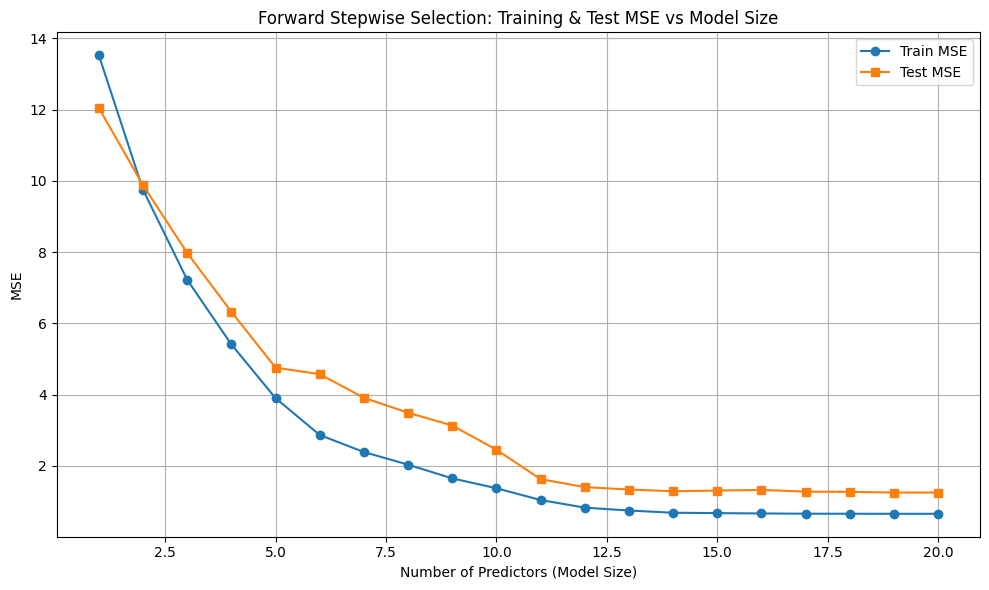

In [113]:
# (10.c) Forward Selection

remaining = list(X_train.columns)

selected = []

train_mse_list = []

test_mse_list = []

for k in range(1, p + 1):
    best_mse = np.inf
    best_feature = None
    
    for feature in remaining:
        current_features = selected + [feature]
        model = LinearRegression().fit(X_train[current_features], y_train)
        y_pred = model.predict(X_train[current_features])
        mse = mean_squared_error(y_train, y_pred)
        
        if mse < best_mse:
            best_mse = mse
            best_feature = feature

    selected.append(best_feature)
    remaining.remove(best_feature)

    model = LinearRegression().fit(X_train[selected], y_train)

    y_train_pred = model.predict(X_train[selected])
    y_test_pred = model.predict(X_test[selected])

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

plt.figure(figsize=(10, 6))
plt.plot(range(1, p + 1), train_mse_list, marker='o', label='Train MSE')
plt.plot(range(1, p + 1), test_mse_list, marker='s', label='Test MSE')
plt.xlabel("Number of Predictors (Model Size)")
plt.ylabel("MSE")
plt.title("Forward Stepwise Selection: Training & Test MSE vs Model Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()